In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import lr_scheduler
from matplotlib import pyplot as plt

def interp1(grid, x, f, axis=0):  # Linear interpolation
    s = torch.ones(f.dim(), dtype=torch.long)
    s[axis] = x.numel()
    s = torch.Size(s)
    ind = torch.searchsorted(grid, x) # indices on the right of x
    ind = torch.minimum(torch.maximum(ind, torch.tensor(1)), torch.tensor(grid.numel()-1))
    gr = grid[ind].view(s)
    gl = grid[ind-1].view(s)
    fr = torch.index_select(f,axis,ind)
    fl = torch.index_select(f,axis,ind-1)
    xt = x.view(s)
    return (fr * (xt - gl) + fl * (gr - xt)) / (gr - gl)

def linearMass(grid):   # Mass matrix of piecewise linear functions
    h = grid[1:] - grid[:-1]
    h = torch.cat([h[0].reshape(1), h, h[-1].reshape(1)])
    M = torch.diag(h[1:-1]/6, -1) + torch.diag(h[1:-1]/6, 1) + torch.diag((h[:-1]+h[1:])/3)
    M[0,0] = h[1]/3 
    M[-1,-1] = h[-1]/3
    return M

def linearLap(grid):    # Laplacian matrix of piecewise linear functions
    h = grid[1:] - grid[:-1]
    h = torch.cat([h[0].reshape(1), h, h[-1].reshape(1)])
    M = torch.diag(-1/h[1:-1], -1) + torch.diag(-1/h[1:-1], 1) + torch.diag(1/h[:-1]+1/h[1:])
    M[0,0] = 1/h[1]
    M[-1,-1] = 1/h[-1]
    return M

class TT(nn.Module): # Discrete TT(i) = <U, e_i> for general purpose with MSE loss
    def __init__(self, n=[1], r=[1,1]):
        super().__init__()
        self.U = nn.ParameterList([nn.Parameter(torch.rand(r[i], n[i], r[i + 1])*1e-3) for i in range(len(n))])

    def loss(self, X, Y):
        return torch.mean((self.forward(X) - Y)**2)        

class TTLin(TT): # Linear TT(x) = <U, \phi(x)> for general purpose with MSE loss
    def __init__(self, grid=[torch.ones(1)], r=[1,1]):
        super().__init__(n=[grid[k].numel() for k in range(len(grid))], r=r)
        self.grid = grid

    def interp_core(self, k, x):
        return interp1(self.grid[k], x, self.U[k], axis=1)
    
    def forward(self, X):
        prod = self.interp_core(0, X[:,0])
        for k in range(1, len(self.U)):
            prod = torch.einsum('ijk,kjl->ijl', prod, self.interp_core(k, X[:,k]))
        return prod
    
class TTSqrDE(TTLin): # Squared TT(x) = <U, \phi(x)>^2 for Density Estimation with log-likelihood loss and normalisation
    def __init__(self, grid=[torch.ones(1)], r=[1,1], Lambda=0):
        super().__init__(grid,r)
        self.Mass = [linearMass(grid[k]) for k in range(len(grid))]
        self.Lambda = Lambda
        if Lambda > 0:
            self.Lap = [[]]*len(grid)
            self.Lap[0] = torch.zeros(1, grid[0].numel(), grid[0].numel(), 2)
            self.Lap[0][0,:,:,0] = linearLap(grid[0])
            self.Lap[0][0,:,:,1] = self.Mass[0]
            for k in range(1,len(grid)):
                self.Lap[k] = torch.zeros(2, grid[k].numel(), grid[k].numel(), 2)
                self.Lap[k][1,:,:,0] = linearLap(grid[k])
                self.Lap[k][0,:,:,0] = self.Mass[k]
                self.Lap[k][1,:,:,1] = self.Mass[k]
            self.Lap[-1] = torch.zeros(2, grid[-1].numel(), grid[-1].numel(), 1)
            self.Lap[-1][0,:,:,0] = self.Mass[-1]        
            self.Lap[-1][1,:,:,0] = linearLap(grid[-1])
        self.marginals = []

    def forward(self, X):        
        return super().forward(X)**2
    
    def normconst(self):
        self.marginals = [torch.ones(1,1)] * (len(self.U)+1)
        for k in range(len(self.U)-1,-1,-1):
            V = torch.einsum('ij,kjl->kil', self.Mass[k], self.U[k])
            self.marginals[k] = torch.einsum('kil,lp,mip->km', V, self.marginals[k+1], self.U[k])
        return self.marginals[0].flatten()
    
    def lap(self):
        if self.Lambda == 0:
            return 0
        sm = torch.ones(1,1,1)
        for k in range(len(self.U)):
            V1 = torch.einsum('kqp,pil->kqil', sm, self.U[k])
            V2 = torch.einsum('kqil,qijr->kjlr', V1, self.Lap[k])
            sm = torch.einsum('kjlr,kjt->lrt', V2, self.U[k])
        return sm.flatten() * self.Lambda

    def normalise(self):
        Z = self.normconst()
        if ((Z-1).abs() > 1e-2):
            print(f"Normalising constant {float(Z)} is far from 1")
        Z = Z**(0.5/len(self.U))
        for k in range(len(self.U)):
            self.U[k].data /= Z
    
    def loss(self, X):  # Log-likelihood Loss
        return torch.mean(torch.log(self.normconst()) - torch.log(self.forward(X))) + self.lap()  # From TERM
        # return -torch.mean(torch.log(self.forward(X)))  # From TERM assuming normalisation
    
    def rt(self, x):
        """
        Forward Rosenblatt transform
        """
        self.normconst() # Compute marginals
        prevcond = torch.ones(len(x),1) # Conditioned left cores
        q = torch.ones_like(x)
        for k in range(len(self.U)):     
            Pprev = torch.einsum('mk,kil->mil', prevcond, self.U[k])
            dP = Pprev[:,1:,:] - Pprev[:,:-1,:]
            Pprev = Pprev[:,:-1,:]
            P0 = torch.einsum('mik,mip,kp->mi', Pprev, Pprev, self.marginals[k+1])
            P1 = torch.einsum('mik,mip,kp->mi', dP, Pprev, self.marginals[k+1]) * 2
            P2 = torch.einsum('mik,mip,kp->mi', dP, dP, self.marginals[k+1])
            h = (self.grid[k][1:] - self.grid[k][:-1]).reshape(1,-1)
            C0h = (P2/3 + P1/2 + P0) * h
            C0h = torch.hstack([torch.zeros(C0h.shape[0], 1), C0h])
            C0h = torch.cumsum(C0h, dim=1)  # CDF on grid
            Zc  = C0h[:,-1].reshape(-1,1)
            izero = (Zc<1e-30).flatten()
            C0h[izero,:] = torch.linspace(0, 1, C0h.shape[1])
            Zc[izero,:] = 1
            P2[izero,:] = 0
            P1[izero,:] = 0
            P0[izero,:] = 1
            C0h = C0h / Zc  # Normalise CDF
            ind = torch.searchsorted(self.grid[k], x[:,k]) - 1 # indices on the left of x
            ind = torch.minimum(torch.maximum(ind, torch.tensor(0)), torch.tensor(self.grid[k].numel()-2))
            ind = ind.reshape(-1,1)
            # C0(z) = (p2*z**3/3 + p1*z**2/2 + p0*z) * h + C0
            P0 = torch.gather(P0, dim=1, index=ind) / Zc
            P1 = torch.gather(P1, dim=1, index=ind) / Zc
            P2 = torch.gather(P2, dim=1, index=ind) / Zc
            C0h = torch.gather(C0h, dim=1, index=ind)
            xl = self.grid[k][ind].reshape(-1,1)
            h = self.grid[k][ind+1].reshape(-1,1) - xl            
            z = (x[:,k].reshape(-1,1) - xl) / h
            q[:,k] = (C0h + (P2 * z**3/3 + P1 * z**2/2 + P0 * z) * h).flatten()
            q[:,k] = torch.maximum(torch.minimum(q[:,k], torch.ones_like(q[:,k])), torch.zeros_like(q[:,k]))
            prevcond = torch.einsum('mk,kml->ml', prevcond, self.interp_core(k, x[:,k]))
            # # Map back to normal
            # q[:,k] = torch.erfinv(2*q[:,k]-1)*torch.sqrt(torch.tensor(2))
        return q


    def irt(self, q):
        """
        Inverse Rosenblatt transform
        """
        # q = torch.erf(qn/torch.sqrt(torch.tensor(2)))/2+0.5
        self.normconst() # Compute marginals
        prevcond = torch.ones(len(q),1) # Conditioned left cores
        lFapp = torch.zeros_like(prevcond)
        x = torch.ones_like(q)        
        for k in range(len(self.U)):            
            Pprev = torch.einsum('mk,kil->mil', prevcond, self.U[k])
            dP = Pprev[:,1:,:] - Pprev[:,:-1,:]
            Pprev = Pprev[:,:-1,:]
            P0 = torch.einsum('mik,mip,kp->mi', Pprev, Pprev, self.marginals[k+1])
            P1 = torch.einsum('mik,mip,kp->mi', dP, Pprev, self.marginals[k+1]) * 2
            P2 = torch.einsum('mik,mip,kp->mi', dP, dP, self.marginals[k+1])
            h = (self.grid[k][1:] - self.grid[k][:-1]).reshape(1,-1)
            # h = xr - xl, dp = pr - pl
            # z = (x-xl)/h
            # p(z) = (pr_k*z + pl_k*(1-z))*P_{kl}*(pr_l*z + pl_l*(1-z))
            #      = (prPpr)*z**2 + (prPpl+plPpr)*z*(1-z) + plPpl*(1-z)**2
            #      = (prPpr+plPpl-prPpl-plPpr)*z**2 + (prPpl+plPpr-2*plPpl)*z + plPpl
            # p0 = plPpl, p1 = prPpl+plPpr-2*p0 = (pr-pl)Ppl + plP(pr-pl), p2 = prPpr-p1-p0 = (pr-pl)P(pr-pl)
            # C0(z) = int_0^z p(s)ds = p2*z**3/3 + p1*z**2/2 + p0*z               * h
            # C0(h) = (p2/3 + p1/2 + p0) * h                        
            C0h = (P2/3 + P1/2 + P0) * h
            C0h = torch.hstack([torch.zeros(C0h.shape[0], 1), C0h])
            C0h = torch.cumsum(C0h, dim=1)  # CDF on grid
            Zc  = C0h[:,-1].reshape(-1,1)
            izero = (Zc<1e-30).flatten()
            C0h[izero,:] = torch.linspace(0, 1, C0h.shape[1])
            Zc[izero,:] = 1
            P2[izero,:] = 0
            P1[izero,:] = 0
            P0[izero,:] = 1
            C0h = C0h / Zc  # Normalise CDF
            ind = torch.searchsorted(C0h, q[:,k].reshape(-1,1)) - 1 # indices on the left of q
            ind = torch.minimum(torch.maximum(ind, torch.tensor(0)), torch.tensor(self.grid[k].numel()-2))
            P0 = torch.gather(P0, dim=1, index=ind) / Zc
            P1 = torch.gather(P1, dim=1, index=ind) / Zc
            P2 = torch.gather(P2, dim=1, index=ind) / Zc
            iconst = (P2 < 1e-30).flatten() # Indices where density is constant
            ivar   = ~iconst
            q0 = q[:,k].reshape(-1,1) - torch.gather(C0h, dim=1, index=ind)
            xl = self.grid[k][ind].reshape(-1,1)
            h = self.grid[k][ind+1].reshape(-1,1) - xl    
            # Sample constant densities -> linear CDF
            z = q0[iconst]/P0[iconst]
            xk = xl[iconst] + torch.min(torch.max(z, torch.zeros_like(z)), h[iconst])
            x[iconst,k] = xk.flatten()
            # Solve the cubic equations for the variable densities
            P0v = P0[ivar]
            P1v = P1[ivar]
            P2v = P2[ivar]
            D0 = P1v**2/4 - P0v*P2v
            D1 = P1v**3/4 - P0v*P1v*P2v*3/2 - 3*P2v**2*q0[ivar]/h[ivar]
            DD = D1**2 - 4*D0**3
            C = (D1 + D1.sign() * torch.sqrt(DD.abs()))/2
            C = C.sign() * C.abs().pow(1.0/3) #   np.cbrt(C.detach().numpy())
            z = -(P1v/2 + C + D0/C)/P2v
            izero = (C.abs()<1e-30).flatten()
            z[izero] = -(P1v[izero]/2)/P2v[izero]
            # res = P2/3 * z**3 + P1/2 * z**2 + P0 * z - q0[ivar]/h[ivar]
            # print(res)
            z = torch.min(torch.max(z, torch.zeros_like(z)), torch.ones_like(z))
            xk = xl[ivar] + z*h[ivar]
            x[ivar,k] = xk.flatten()
            # Condition the current core
            prevcond = torch.einsum('mk,kml->ml', prevcond, self.interp_core(k, x[:,k]))
            z = (x[:,k].reshape(-1,1) - xl)/h
            lFapp += torch.log(P2 * z**2 + P1 * z + P0)
        return x, lFapp
    
    def cross(self, fun, tol=1e-6, nswp=20, kickrank=4, dir=1):
        """
        Amen-cross approximation
        fun should take samples of shape (M, d) and return a tensor of shape (M, m)
        """
        
        # Aux functions
        def maxvol2(A, niters=100, eps=1e-2):
            """
            Maxvol algorithm for selecting the most important rows of a matrix
            """
            P,L,U = torch.linalg.lu(A)
            ind = torch.argmax(P, dim=0)[:A.shape[1]]
            B = torch.linalg.solve(A[ind,:], A, left=False)
            for _ in range(niters):
                big_ind = torch.argmax(torch.abs(B))
                i0, j0 = torch.unravel_index(big_ind, A.shape)
                if torch.abs(B[i0, j0]) <= 1 + eps:
                    break
                k = ind[j0]
                B += B[:, j0].reshape(-1,1) @ ((B[k, :] - B[i0, :]) / B[i0, j0]).reshape(1,-1)
                ind[j0] = i0
            return ind

        def qrmaxvol_block(yl, yr, dir, z=None):
            """
            Move non-orth center between the blocks, computing enrich, QR and maxvol
            """
            r0, nl, _, bl = yl.shape
            _, nr, r2, br = yr.shape

            if dir > 0:
                # Reshape all
                yl = yl.reshape(r0 * nl, -1)
                r1 = yl.shape[1]
                if z is not None:
                    # Enrich
                    yl = torch.hstack([yl, z])

                # QR
                yl, rv = torch.linalg.qr(yl)
                rv = rv[:, :r1]

                # Maxvol and divide
                ind = maxvol2(yl)
                YY = yl[ind, :]
                yl = torch.linalg.solve(YY, yl, left=False)

                # Update r
                r1 = yl.shape[1]
                yl = yl.reshape(r0, nl, r1, bl)

                # Cast non-orths
                rv = YY @ rv
                yr = yr.reshape(-1, nr * r2 * br)
                yr = rv @ yr
                yr = yr.reshape(r1, nr, r2, br)
            else:
                # Reshape all
                yr = yr.reshape(-1, nr * r2)
                r1 = yr.shape[0]
                if z is not None:
                    # Enrich
                    yr = torch.vstack([yr, z])

                # QR
                yr = yr.T
                yr, rv = torch.linalg.qr(yr)
                rv = rv[:, :r1]

                # Maxvol and divide
                # Replace maxvol2 function with its Python equivalent
                ind = maxvol2(yr)  # maxvol2 function needs to be defined separately
                yr = yr.T
                YY = yr[:, ind]
                yr = torch.linalg.solve(YY, yr, left=True)

                # Update r
                r1 = yr.shape[0]
                yr = yr.reshape(r1, nr, r2, br)

                # Cast non-orths
                rv = rv.T @ YY
                yl = yl.reshape(-1, bl)
                yl = yl.T
                yl = yl.reshape(bl * r0 * nl, -1)
                yl = yl @ rv
                yl = yl.reshape(bl, r0 * nl * r1)
                yl = yl.T
                yl = yl.reshape(r0, nl, r1, bl)

            return yl, yr, ind

        def indexmerge(X1, X2, X3=None):
            """
            Merge indices with direct sum
            """
            Y = X2.reshape(1, X2.shape[0], 1, X2.shape[1])
            if X1 is not None:
                X1 = X1.reshape(X1.shape[0], 1, 1, X1.shape[1])
                X1 = torch.tile(X1, [1, Y.shape[1], 1, 1])
                Y = torch.tile(Y, [X1.shape[0], 1, 1, 1])
                Y = torch.cat([X1, Y], dim=3)
            if X3 is not None:
                X3 = X3.reshape(1, 1, X3.shape[0], X3.shape[1])
                X3 = torch.tile(X3, [Y.shape[0], Y.shape[1], 1, 1])
                Y = torch.tile(Y, [1, 1, X3.shape[2], 1])
                Y = torch.cat([Y, X3], dim=3)
            return Y.reshape(-1, Y.shape[-1])
        
        def ind2samples(grid, ind):
            """
            Convert indices to samples
            """
            return torch.hstack([grid[i][indi].reshape(-1,1) for i, indi in enumerate(ind.T)])

        def start_stop_pos(d, dir):
            """
            Start, end, prev and next dimensions for the cross
            """
            if dir > 0:
                return 0, d, 0, 1
            else:
                return d-1, -1, 1, 0

        # The cross itself starts here
        d = len(self.U)
        n = [g.numel() for g in self.grid]
        # Initial indices
        if (dir>0):
            J = [None]+[torch.randint(low=0, high=self.U[i].shape[1], size=(self.U[i].shape[0],len(self.U)-i)) for i in range(1,len(self.U))]+[None]
        # Initial QR - goes in the reverse of dir
        istart, iend, iprev, inext = start_stop_pos(d, -dir) # Where we start and move next
        for i in range(istart, iend+dir, -dir):
            self.U[i+inext] = self.U[i+inext].reshape(self.U[i+inext].shape[0], n[i+inext], self.U[i+inext].shape[2], 1)
            self.U[i-iprev] = self.U[i-iprev].reshape(self.U[i-iprev].shape[0], n[i-iprev], self.U[i-iprev].shape[2], 1)
            self.U[i-iprev], self.U[i+inext], ind = qrmaxvol_block(self.U[i-iprev], self.U[i+inext], -dir)

        evalcnt = 0
        for swp in range(nswp):
            istart, iend, iprev, inext = start_stop_pos(d, dir) # Where we start and move next
            max_err = 0            
            for i in range(istart, iend, dir):
                # Sample
                X = ind2samples(self.grid, indexmerge(J[i], torch.arange(n[i]).reshape(-1,1), J[i+1]))
                Y = fun(X)
                evalcnt += X.shape[0]
                Y = Y.reshape(self.U[i].shape)
                err = torch.norm(Y - self.U[i]) / torch.norm(Y)
                print(f"\t swp = {swp}.{i}: err = {err:.3e}")
                max_err = max(max_err, err)
                self.U[i] = Y
                if i != iend-dir:
                    # Move non-orth center
                    self.U[i-iprev], self.U[i+inext], ind = qrmaxvol_block(self.U[i-iprev], self.U[i+inext], dir)
                    # Restrict new indices
                    if dir > 0:
                        J[i+inext] = indexmerge(J[i], torch.arange(n[i]).reshape(-1,1), None)
                    else:
                        J[i+inext] = indexmerge(None, torch.arange(n[i]).reshape(-1,1), J[i+1])
                    J[i+inext] = J[i+inext][ind, :]

            print(f"Cross sweep {swp}: max_err = {max_err:.3e}, cum#evals = {evalcnt}")
            if max_err < tol:
                break
            dir = -dir

        for i in range(d):
            self.U[i] = self.U[i].reshape(self.U[i].shape[0], n[i], self.U[i].shape[2])
        return evalcnt    
        

	 swp = 0.0: err = 1.000e+00
	 swp = 0.1: err = 3.445e-01
Cross sweep 0: max_err = 1.000e+00, cum#evals = 40
	 swp = 1.1: err = 0.000e+00
	 swp = 1.0: err = 6.725e-07
Cross sweep 1: max_err = 6.725e-07, cum#evals = 80


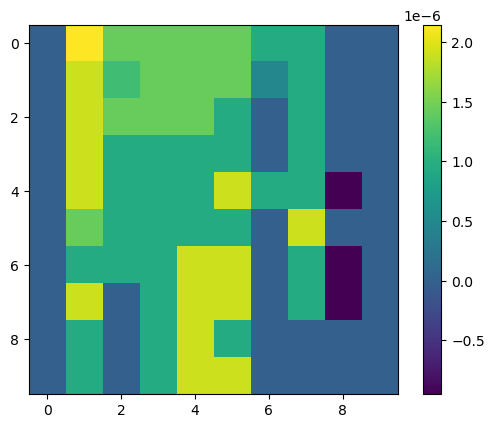

In [228]:
t = TTSqrDE([torch.linspace(0,9,10)]*2, [1,2,1])
t.cross(lambda x: torch.sum(x, dim=1, keepdim=True), nswp=5)
# t.cross(lambda x: torch.ones(x.shape[0], 1), nswp=5)
X1, X2 = torch.meshgrid(torch.linspace(0,9,10), torch.linspace(0,9,10))
plt.imshow( (t.forward(torch.hstack([X1.reshape(-1,1), X2.reshape(-1,1)]))**(1/2)).reshape(X1.shape).detach().numpy() - (X1+X2).detach().numpy() )
plt.colorbar()